In [41]:
from typing import Optional
from dataclasses import dataclass
import cv2
import polars as pl
from IPython.display import Image, display
from collections.abc import Iterable
from typing import Any, Generator
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

# Image analysis 

In [2]:
@dataclass
class Color:
    """
    RGB color represented as integers in the range [0, 255].
    """
    r: int
    g: int
    b: int

    def __post_init__(self):
        assert 0 <= self.r <= 255
        assert 0 <= self.g <= 255
        assert 0 <= self.b <= 255

    def to_bgr_tuple(self) -> tuple[int, int, int]:
        return self.b, self.g, self.r


@dataclass
class Point:
    """
    A class representing a point in a 2D grid. r is the row index, c is the column index.
    """
    r: int
    c: int


def validate_point(point: Point, img):
    """Check if the point is within the image boundaries"""
    img_height, img_width, _ = img.shape
    if not (0 <= point.r < img_height and 0 <= point.c < img_width):
        raise ValueError(
            f"Point ({point.r}, {point.c}) is outside the image boundaries. Image size: {img_width}x{img_height}")


def get_pixel_color(point: Point, img) -> Color:
    """Get color of the pixel at the given image"""
    validate_point(point, img)
    b, g, r = img[point.r, point.c]
    return Color(int(r), int(g), int(b))  # Convert to RGB for consistency


def update_pixel_color(point: Point, img, color: Color):
    """Update the color of the pixel at the given image, return updated image"""
    validate_point(point, img)
    img[point.r, point.c] = color.to_bgr_tuple()
    return img


[[Point(r=100, c=280), Point(r=100, c=304), Point(r=100, c=328), Point(r=100, c=352), Point(r=100, c=376)], [Point(r=124, c=280), Point(r=124, c=304), Point(r=124, c=328), Point(r=124, c=352), Point(r=124, c=376)], [Point(r=148, c=280), Point(r=148, c=304), Point(r=148, c=328), Point(r=148, c=352), Point(r=148, c=376)], [Point(r=172, c=280), Point(r=172, c=304), Point(r=172, c=328), Point(r=172, c=352), Point(r=172, c=376)], [Point(r=196, c=280), Point(r=196, c=304), Point(r=196, c=328), Point(r=196, c=352), Point(r=196, c=376)], [Point(r=220, c=280), Point(r=220, c=304), Point(r=220, c=328), Point(r=220, c=352), Point(r=220, c=376)]]
(280, 512, 3)


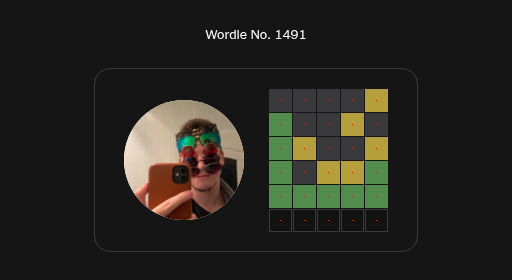

In [42]:


def get_cell_coordinates(first_cell_pos: Point, matrix_size: tuple[int, int], intercell_interval_px: int,
                         cell_size_px: Point) -> list[list[Point]]:
    """Generate list of coordinates of all cells in the matrix"""
    return [
        [Point(first_cell_pos.r + (intercell_interval_px + cell_size_px.r) * j,
               first_cell_pos.c + (intercell_interval_px + cell_size_px.c) * i) for i in range(matrix_size[1])]
        for j in range(matrix_size[0])
    ]


def flatten(nested: Iterable[Any]) -> Generator[Any, None, None]:
    """Recursively flatten any nested iterable into a flat generator."""
    for item in nested:
        if isinstance(item, Iterable) and not isinstance(item, (str, bytes)):
            yield from flatten(item)
        else:
            yield item

# get coordinates using https://pixspy.com/
cell_size_px = Point(23, 23)  # size of each cell in pixels
intercell_interval_px = 1  # space between cells in pixel
matrix_size = (6, 5)  # number of cells in each direction (rows, columns)

first_cell_pos = Point(100, 280)  # middle of the top left corner cell
# first_cell_pos = Point(89, 269)  # top left corner of the top left cell


cell_coordinates = get_cell_coordinates(
    first_cell_pos=first_cell_pos,
    matrix_size=matrix_size,
    intercell_interval_px=intercell_interval_px,
    cell_size_px=cell_size_px
)

print(cell_coordinates)

test_file = "imgs/2025-07-19T12:19:04.279000+00:00.png"
test_img = cv2.imread(test_file)
red = Color(255, 0, 0)
print(test_img.shape)

for point in flatten(cell_coordinates):
    # update the image by adding red pixel in the middle of each cell
    update_pixel_color(point, test_img, red)

cv2.imwrite("test_bruh.png", test_img)
display(Image(filename="test_bruh.png"))


In [43]:
from copy import deepcopy

correct_place_color = Color(83, 141, 78)
correct_letter_color = Color(181, 159, 59)
wrong_letter_color = Color(58, 58, 60)
empty_color = Color(18, 18, 19)


def print_matrix(matrix: list[list]):
    for row in matrix:
        print(''.join(str(elem) for elem in row))


def get_wordle_matrix(img, cell_coordinates: list[list[Point]], output_type: str = "str") -> list[list[str]] | list[list[float]]:
    matrix = deepcopy(
        cell_coordinates)  # using the same matrix as before but now instead of coordinates we will get the cell color
    for r, row in enumerate(cell_coordinates):
        for c, point in enumerate(row):
            cell_color = get_pixel_color(point, img)
            cell_color_emoji: str
            match cell_color:
                case _ if cell_color == correct_place_color:
                    cell_color_emoji = "🟩" if output_type == "str" else 1.0
                case _ if cell_color == correct_letter_color:
                    cell_color_emoji = "🟨" if output_type == "str" else 0.5
                case _ if cell_color == wrong_letter_color:
                    cell_color_emoji = "⬜️️" if output_type == "str" else 0.0
                case _ if cell_color == empty_color:
                    cell_color_emoji = "⬛" if output_type == "str" else None
                case _:
                    cell_color_emoji = "❌" if output_type == "str" else -1000000.0
            matrix[r][c] = cell_color_emoji
    return matrix

test_file = "imgs/2025-07-19T12:19:04.279000+00:00.png"
test_img = cv2.imread(test_file)

print_matrix(get_wordle_matrix(test_img, cell_coordinates))
# print_matrix(get_wordle_matrix(test_img, "int"))

⬜️️⬜️️⬜️️⬜️️🟨
🟩⬜️️⬜️️🟨⬜️️
🟩🟨⬜️️⬜️️🟨
🟩⬜️️🟨🟨🟩
🟩🟩🟩🟩🟩
⬛⬛⬛⬛⬛


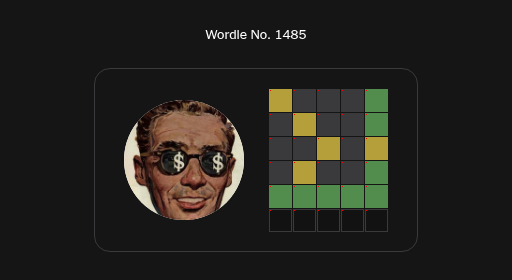

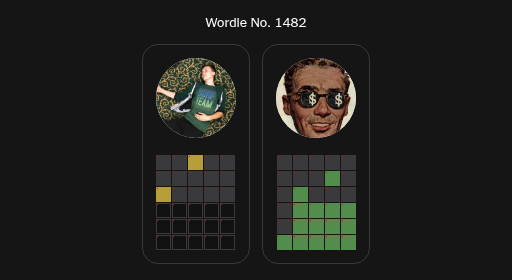

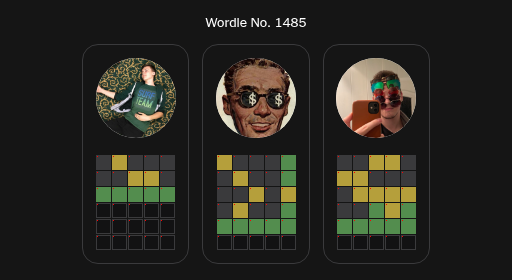

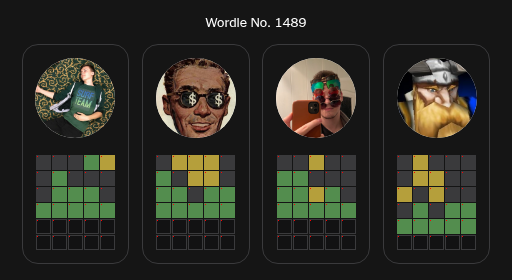

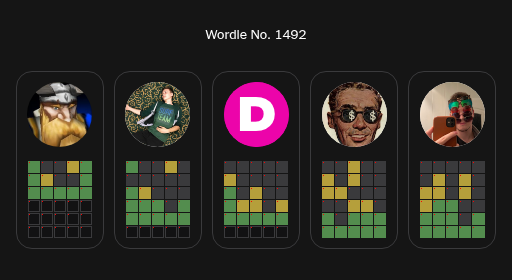

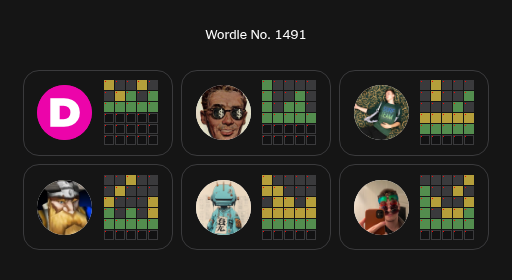

In [44]:


@dataclass
class Layout:
    users: int  # int number of participants
    cell_size_px: Point
    first_cell_positions: list[Point]  # list of all positions of first cells
    intercell_interval_px: int = 1
    matrix_size = (6, 5)  # number of cells in each direction (rows, columns)

    def get_cell_coordinates(self) -> dict[int, list[list[Point]]]:
        """Get dict with key as a user number on the layout, and value as it's matrix coordinates"""
        coordinates = dict()
        for i, position in enumerate(self.first_cell_positions):
            coordinates[i] = [
                [Point(position.r + (self.intercell_interval_px + self.cell_size_px.r) * j,
                       position.c + (self.intercell_interval_px + self.cell_size_px.c) * i) for i in
                 range(self.matrix_size[1])]
                for j in range(self.matrix_size[0])
            ]
        return coordinates


result_grid = {
    1: Layout(
        users=1,
        cell_size_px=Point(23, 23),
        first_cell_positions=[
            Point(90, 270)
        ]
    ),
    2: Layout(
        users=2,
        cell_size_px=Point(15, 15),
        first_cell_positions=[
            Point(156, 157),
            Point(156, 278)
        ]
    ),
    3: Layout(
        users=3,
        cell_size_px=Point(15, 15),
        first_cell_positions=[
            Point(156, 97),
            Point(156, 218),
            Point(156, 338)
        ]
    ),
    4: Layout(
        users=4,
        cell_size_px=Point(15, 15),
        first_cell_positions=[
            Point(156, 37),
            Point(156, 157),
            Point(156, 278),
            Point(156, 398),
        ]
    ),
    5: Layout(
        users=5,
        cell_size_px=Point(12, 12),
        first_cell_positions=[
            Point(162, 29),
            Point(162, 127),
            Point(162, 225),
            Point(162, 323),
            Point(162, 421)
        ]
    ),
    6: Layout(
        users=6,
        cell_size_px=Point(10, 10),
        first_cell_positions=[
            Point(81, 105),
            Point(81, 263),
            Point(81, 421),
            Point(176, 105),
            Point(176, 263),
            Point(176, 421)
        ]
    )
}


def color_red_daily_results(daily_image, users_cnt: int):
    layout = result_grid[users_cnt]
    for cell_coordinates in layout.get_cell_coordinates().values():
        for point in flatten(cell_coordinates):
            update_pixel_color(point, daily_image, red)
    return daily_image


# img path and number of participants
test_files = [
    ("2025-07-13T03:33:14.292000+00:00.png", 1),
    ("2025-07-09T22:11:54.838000+00:00.png", 2),
    ("2025-07-14T03:33:17.903000+00:00.png", 3),
    ("2025-07-17T21:18:17.261000+00:00.png", 4),
    ("2025-07-20T22:48:11.667000+00:00.png", 5),
    ("2025-07-19T22:38:13.788000+00:00.png", 6)
]
for file, users_cnt in test_files:
    daily_image = cv2.imread(f"layout_example_imgs/{file}")
    color_red_daily_results(daily_image, users_cnt)
    cv2.imwrite(f"layout_example_red/{users_cnt}.png", daily_image)
    display(Image(filename=f"layout_example_red/{users_cnt}.png"))



In [45]:
def get_daily_results(daily_image, layout: Layout, output_type: str = "str") -> \
        list[list[str]] | list[list[float]]:
    matrices = []
    for cell_coordinates in layout.get_cell_coordinates().values():
        # using the same matrix as before but now instead of coordinates we will get the cell color
        matrix = get_wordle_matrix(daily_image, cell_coordinates, output_type=output_type)
        matrices.append(matrix)
    return matrices


for file, users_cnt in test_files[-1:]:
    layout = result_grid[users_cnt]
    daily_image = cv2.imread(f"layout_example_imgs/{file}")
    matrices = get_daily_results(daily_image, layout)
    for matrix in matrices:
        print(f"========{users_cnt}========")
        print_matrix(matrix)

========6========
🟨⬜️️⬜️️🟨⬜️️
⬜️️🟨🟩⬜️️🟩
🟩🟩🟩🟩🟩
⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛
========6========
🟩⬜️️⬜️️⬜️️⬜️️
🟩⬜️️⬜️️🟩⬜️️
🟩⬜️️🟩🟩⬜️️
🟩🟩🟩🟩🟩
⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛
========6========
⬜️️🟨⬜️️⬜️️⬜️️
⬜️️🟨⬜️️⬜️️🟩
⬜️️⬜️️⬜️️🟩⬜️️
🟨🟨🟨🟨🟨
🟩🟩🟩🟩🟩
⬛⬛⬛⬛⬛
========6========
⬜️️⬜️️🟨⬜️️⬜️️
⬜️️🟨⬜️️⬜️️⬜️️
🟨⬜️️⬜️️⬜️️🟨
🟩⬜️️🟩⬜️️🟨
🟩🟩🟩🟩🟩
⬛⬛⬛⬛⬛
========6========
🟨⬜️️⬜️️⬜️️⬜️️
🟨🟨⬜️️⬜️️⬜️️
⬜️️🟨🟨⬜️️🟨
🟨🟨🟨🟨🟨
🟩🟩🟩🟩🟩
⬛⬛⬛⬛⬛
========6========
⬜️️⬜️️⬜️️⬜️️🟨
🟩⬜️️⬜️️🟨⬜️️
🟩🟨⬜️️⬜️️🟨
🟩⬜️️🟨🟨🟩
🟩🟩🟩🟩🟩
⬛⬛⬛⬛⬛


# Data Analysis

In [46]:
messages_df = pl.read_json("discord_messages.json")
messages_df.schema

Schema([('author', String),
        ('author_nickname', String),
        ('author_id', Int64),
        ('content', String),
        ('timestamp', String),
        ('images_urls', List(String))])

In [47]:
messages_df.describe()


statistic,author,author_nickname,author_id,content,timestamp,images_urls
str,str,str,f64,str,str,f64
"""count""","""1547""","""1547""",1547.0,"""1547""","""1547""",1547.0
"""null_count""","""0""","""0""",0.0,"""0""","""0""",0.0
"""mean""",null,null,6.0021e17,null,null,null
"""std""",null,null,2.5820e17,null,null,null
"""min""","""Chill Party bot""","""Altf4""",1.2166e17,"""""","""2024-02-10T10:29:52.183000+00:00""",null
"""25%""",null,null,3.9417e17,null,null,null
"""50%""",null,null,4.6263e17,null,null,null
"""75%""",null,null,6.6241e17,null,null,null
"""max""","""zurg_g""","""Чугайстер""",1.3899e18,"""👆это Париж""","""2025-07-25T22:25:51.038000+00:00""",null


In [49]:
wordle_messages = messages_df.filter(pl.col("author_id") == 1211781489931452447).filter(pl.col("content").str.contains("\\*\\*Your group is on a"))
wordle_messages.describe()

statistic,author,author_nickname,author_id,content,timestamp,images_urls
str,str,str,f64,str,str,f64
"""count""","""40""","""40""",40.0,"""40""","""40""",40.0
"""null_count""","""0""","""0""",0.0,"""0""","""0""",0.0
"""mean""",null,null,1.2118e18,null,null,null
"""std""",null,null,0.0,null,null,null
"""min""","""Wordle""","""Wordle""",1.2118e18,"""**Your group is on a 1 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@444185680474800129>\n6/6: <@394171450120208389>""","""2025-06-13T22:41:03.744000+00:00""",null
"""25%""",null,null,1.2118e18,null,null,null
"""50%""",null,null,1.2118e18,null,null,null
"""75%""",null,null,1.2118e18,null,null,null
"""max""","""Wordle""","""Wordle""",1.2118e18,"""**Your group is on an 8 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@662414928350806044>\n5/6: <@690142381726892042>\n6/6: <@394171450120208389> <@444185680474800129>""","""2025-07-25T21:55:13.103000+00:00""",null


In [50]:
display(wordle_messages.select("timestamp", "content").sort("timestamp", descending=False).head(10))


timestamp,content
str,str
"""2025-06-13T22:41:03.744000+00:00""","""**Your group is on a 1 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@690142381726892042>\nX/6: <@444185680474800129>"""
"""2025-06-16T21:08:12.672000+00:00""","""**Your group is on a 1 day streak!** 🔥 Here are yesterday's results:\n👑 5/6: <@394171450120208389>\n6/6: <@690142381726892042>"""
"""2025-06-17T21:09:19.854000+00:00""","""**Your group is on a 2 day streak!** 🔥 Here are yesterday's results:\n👑 6/6: <@394171450120208389> <@444185680474800129> <@690142381726892042>"""
"""2025-06-18T22:15:21.977000+00:00""","""**Your group is on a 3 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@662414928350806044> <@444185680474800129>\n6/6: <@394171450120208389>\nX/6: <@690142381726892042>"""
"""2025-06-20T06:25:09.680000+00:00""","""**Your group is on a 4 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: @Sashix <@444185680474800129>\n5/6: <@662414928350806044>"""
"""2025-06-21T05:25:26.850000+00:00""","""**Your group is on a 5 day streak!** 🔥 Here are yesterday's results:\n👑 3/6: <@394171450120208389> <@444185680474800129>\n5/6: <@662414928350806044>"""
"""2025-06-22T05:39:04.985000+00:00""","""**Your group is on a 6 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@444185680474800129>\n5/6: <@394171450120208389>\n6/6: <@662414928350806044>"""
"""2025-06-23T06:16:24.472000+00:00""","""**Your group is on a 7 day streak!** 🔥 Here are yesterday's results:\n👑 5/6: <@444185680474800129>\n6/6: <@394171450120208389> <@245636855993729025>"""
"""2025-06-25T06:03:06.377000+00:00""","""**Your group is on a 1 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@444185680474800129>\n6/6: <@394171450120208389>"""


In [51]:
fixed_timestamp = wordle_messages.with_columns(
    timestamp_raw=pl.col("timestamp"),
    timestamp=pl.col("timestamp")
    .str.to_datetime(time_zone="UTC")  # parse string as UTC datetime
    .dt.convert_time_zone("Europe/Kyiv")  # convert to Kyiv time
)

print(fixed_timestamp.schema)
pl.Config.set_fmt_str_lengths(1000)  # optionally widen formatting

display(fixed_timestamp.select("timestamp", "content").sort("timestamp", descending=False).head(20))


Schema({'author': String, 'author_nickname': String, 'author_id': Int64, 'content': String, 'timestamp': Datetime(time_unit='us', time_zone='Europe/Kyiv'), 'images_urls': List(String), 'timestamp_raw': String})


timestamp,content
"datetime[μs, Europe/Kyiv]",str
2025-06-14 01:41:03.744 EEST,"""**Your group is on a 1 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@690142381726892042>\nX/6: <@444185680474800129>"""
2025-06-17 00:08:12.672 EEST,"""**Your group is on a 1 day streak!** 🔥 Here are yesterday's results:\n👑 5/6: <@394171450120208389>\n6/6: <@690142381726892042>"""
2025-06-18 00:09:19.854 EEST,"""**Your group is on a 2 day streak!** 🔥 Here are yesterday's results:\n👑 6/6: <@394171450120208389> <@444185680474800129> <@690142381726892042>"""
2025-06-19 01:15:21.977 EEST,"""**Your group is on a 3 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@662414928350806044> <@444185680474800129>\n6/6: <@394171450120208389>\nX/6: <@690142381726892042>"""
2025-06-20 09:25:09.680 EEST,"""**Your group is on a 4 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: @Sashix <@444185680474800129>\n5/6: <@662414928350806044>"""
2025-06-21 08:25:26.850 EEST,"""**Your group is on a 5 day streak!** 🔥 Here are yesterday's results:\n👑 3/6: <@394171450120208389> <@444185680474800129>\n5/6: <@662414928350806044>"""
2025-06-22 08:39:04.985 EEST,"""**Your group is on a 6 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@444185680474800129>\n5/6: <@394171450120208389>\n6/6: <@662414928350806044>"""
2025-06-23 09:16:24.472 EEST,"""**Your group is on a 7 day streak!** 🔥 Here are yesterday's results:\n👑 5/6: <@444185680474800129>\n6/6: <@394171450120208389> <@245636855993729025>"""
2025-06-25 09:03:06.377 EEST,"""**Your group is on a 1 day streak!** 🔥 Here are yesterday's results:\n👑 4/6: <@444185680474800129>\n6/6: <@394171450120208389>"""


In [52]:
# get user id, nickname and name from discord messages
users = (
    messages_df
    .select(
        pl.col("author").alias("user"),
        pl.col("author_nickname").alias("user_nickname"),
        pl.col("author_id").alias("user_id"),
    )
    .unique()
)
display(users)

user,user_nickname,user_id
str,str,i64
"""pyrnaiasalochka_28684""","""Пырная салочка""",1128385617508712500
"""cian0835""","""Cian""",453210991329804288
"""kanych_""","""Kanych""",284020786547654656
"""rikorlaft""","""Rikorlaft""",506935200077316117
"""tar3an4ik""","""Tar3an4ik""",521082874829471754
"""wentivie""","""went’""",610843409774804992
"""sashix1""","""Sashix""",394171450120208389
"""andiseeyou""","""AndiSeeYou""",1079010665932537897
"""sempej__z_tvoho_pidjizdu""","""user name""",465852082755338241


In [53]:
users.group_by("user_id").len().sort("len", descending=True).head(5)

user_id,len
i64,u32
1013098697103511683,1
458722461148512263,1
1149085246638280734,1
690142381726892042,1
462625683546308618,1


In [56]:
# get users score by day and layouts
# "**Your group is on a 26 day streak!** 🔥 Here are yesterday's results:\n👑
# 3/6: <@690144562202542209>\n4/6: <@394171450120208389>\n5/6: <@690142381726892042> <@662414928350806044> <@245636855993729025> <@444185680474800129>"

users_score = (
    fixed_timestamp
    .with_columns(
        # get only date part of timestamp. Extract 1 day to get actual competition date, not results message date
        pl.col("timestamp").dt.offset_by("-1d").dt.date().alias("date_only"),
        pl.col("content")
        .str.extract(r"🔥 Here are yesterday's results:\\n👑 (.+)")
        .str.split("\\n")
        .alias("results_raw")
    )
    .explode("results_raw")
    .with_columns(results_raw=pl.col("results_raw").str.strip_chars())
    .with_columns(
        score=pl.col("results_raw").str.extract(r"^(\d|X)/6"),
        users=pl.col("results_raw").str.extract_all(r"<@(\d+)>|@(\w+)")
    )
    .explode("users")
    .select(pl.col("users").alias("user"), "score", "timestamp_raw", "date_only")
    .with_columns(
        user_id=pl.col("user").str.extract(r"<@(\d+)>").str.to_integer(),
        user_nickname=pl.col("user").str.extract(r"^@([\w_]+)")
    )
    .join(
        users,
        on="user_nickname",
        how="left"
    )
    .with_columns(
        user_id=pl.coalesce(pl.col("user_id"), pl.col("user_id_right"))
    )
    .select("user_id", "user_nickname", "date_only", "timestamp_raw", pl.col("score").str.to_integer(strict=False))
    .join(
        users,
        on="user_id",
        how="left"
    )
    .select("user_id", pl.col("user_nickname_right").alias("user_nickname"), "date_only", "timestamp_raw", "score")
    .with_columns(pl.int_range(0, pl.len()).over("date_only").alias("user_number"))
    .with_columns(pl.col("user_number").max().over("date_only").alias("users_cnt") + 1)
    .with_columns(img_path=pl.format("imgs/{}.png", pl.col("timestamp_raw")))
)

users_score.head(100)


user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path
i64,str,date,str,i64,i64,i64,str
690142381726892042,"""Kostian_check""",2025-07-25,"""2025-07-25T21:55:13.103000+00:00""",5,0,3,"""imgs/2025-07-25T21:55:13.103000+00:00.png"""
394171450120208389,"""Sashix""",2025-07-25,"""2025-07-25T21:55:13.103000+00:00""",5,1,3,"""imgs/2025-07-25T21:55:13.103000+00:00.png"""
444185680474800129,"""Wahnsinn""",2025-07-25,"""2025-07-25T21:55:13.103000+00:00""",6,2,3,"""imgs/2025-07-25T21:55:13.103000+00:00.png"""
690142381726892042,"""Kostian_check""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",4,0,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png"""
394171450120208389,"""Sashix""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",5,1,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png"""
690144562202542209,"""DED""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",5,2,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png"""
662414928350806044,"""demaga""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",5,3,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png"""
444185680474800129,"""Wahnsinn""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",null,4,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png"""
662414928350806044,"""demaga""",2025-07-23,"""2025-07-23T21:14:12.389000+00:00""",4,0,4,"""imgs/2025-07-23T21:14:12.389000+00:00.png"""


In [57]:
users_score.filter(pl.col("date_only") == pl.date(2025, 7, 19))

user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path
i64,str,date,str,i64,i64,i64,str
690144562202542209,"""DED""",2025-07-19,"""2025-07-19T22:38:13.788000+00:00""",3,0,6,"""imgs/2025-07-19T22:38:13.788000+00:00.png"""
394171450120208389,"""Sashix""",2025-07-19,"""2025-07-19T22:38:13.788000+00:00""",4,1,6,"""imgs/2025-07-19T22:38:13.788000+00:00.png"""
690142381726892042,"""Kostian_check""",2025-07-19,"""2025-07-19T22:38:13.788000+00:00""",5,2,6,"""imgs/2025-07-19T22:38:13.788000+00:00.png"""
662414928350806044,"""demaga""",2025-07-19,"""2025-07-19T22:38:13.788000+00:00""",5,3,6,"""imgs/2025-07-19T22:38:13.788000+00:00.png"""
245636855993729025,"""ZAKA""",2025-07-19,"""2025-07-19T22:38:13.788000+00:00""",5,4,6,"""imgs/2025-07-19T22:38:13.788000+00:00.png"""
444185680474800129,"""Wahnsinn""",2025-07-19,"""2025-07-19T22:38:13.788000+00:00""",5,5,6,"""imgs/2025-07-19T22:38:13.788000+00:00.png"""


In [58]:
def proccess_image(img_path: str, users_cnt: int, user_number: int, output_type: str = "int"):
    layout = result_grid[users_cnt]
    daily_image = cv2.imread(img_path)
    matrix = get_daily_results(daily_image, layout, output_type)[user_number]
    if output_type == "int":
        return np.array(matrix)
    else: 
        return matrix

users_score_test = users_score.with_columns([
    pl.struct(["img_path", "users_cnt", "user_number"]).map_elements(
        lambda row: proccess_image(row["img_path"], row["users_cnt"], row["user_number"], "str")
    ).alias("matrices")
])
print_matrix(users_score_test.select("matrices").head(1).item().to_list())
users_score_test.head(1)


/var/folders/6k/pgkjzwf5565dsnb9yf06xcxm0000gn/T/ipykernel_16243/847798498.py:10: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



⬜️️🟨⬜️️⬜️️🟨
🟨🟨⬜️️⬜️️⬜️️
⬜️️🟨🟨⬜️️⬜️️
⬜️️🟩⬜️️⬜️️🟨
🟩🟩🟩🟩🟩
⬛⬛⬛⬛⬛


user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,list[list[str]]
690142381726892042,"""Kostian_check""",2025-07-25,"""2025-07-25T21:55:13.103000+00:00""",5,0,3,"""imgs/2025-07-25T21:55:13.103000+00:00.png""","[[""⬜️️"", ""🟨"", … ""🟨""], [""🟨"", ""🟨"", … ""⬜️️""], … [""⬛"", ""⬛"", … ""⬛""]]"


In [59]:
users_score = users_score.with_columns([
    pl.struct(["img_path", "users_cnt", "user_number"]).map_elements(
        lambda row: proccess_image(row["img_path"], row["users_cnt"], row["user_number"], "int")
    ).alias("matrices")
])
print(users_score.select("matrices").head(1).item())


/var/folders/6k/pgkjzwf5565dsnb9yf06xcxm0000gn/T/ipykernel_16243/2462966694.py:1: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



[[0.0 0.5 0.0 0.0 0.5]
 [0.5 0.5 0.0 0.0 0.0]
 [0.0 0.5 0.5 0.0 0.0]
 [0.0 1.0 0.0 0.0 0.5]
 [1.0 1.0 1.0 1.0 1.0]
 [None None None None None]]


In [60]:
users_score.head(10)

user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,object
690142381726892042,"""Kostian_check""",2025-07-25,"""2025-07-25T21:55:13.103000+00:00""",5,0,3,"""imgs/2025-07-25T21:55:13.103000+00:00.png""",[[0.0 0.5 0.0 0.0 0.5] [0.5 0.5 0.0 0.0 0.0] [0.0 0.5 0.5 0.0 0.0] [0.0 1.0 0.0 0.0 0.5] [1.0 1.0 1.0 1.0 1.0] [None None None None None]]
394171450120208389,"""Sashix""",2025-07-25,"""2025-07-25T21:55:13.103000+00:00""",5,1,3,"""imgs/2025-07-25T21:55:13.103000+00:00.png""",[[0.5 0.5 0.0 0.0 0.0] [0.0 1.0 0.5 1.0 0.0] [1.0 1.0 0.0 1.0 1.0] [1.0 1.0 0.0 1.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]]
444185680474800129,"""Wahnsinn""",2025-07-25,"""2025-07-25T21:55:13.103000+00:00""",6,2,3,"""imgs/2025-07-25T21:55:13.103000+00:00.png""",[[0. 0. 0. 1. 0.] [0. 0. 0. 1. 1.] [0. 0. 0. 1. 1.] [0. 0. 0. 1. 1.] [0. 1. 0. 1. 1.] [1. 1. 1. 1. 1.]]
690142381726892042,"""Kostian_check""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",4,0,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png""",[[0.0 0.0 1.0 0.0 0.0] [0.0 0.0 0.5 0.0 0.0] [0.5 0.0 1.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None] [None None None None None]]
394171450120208389,"""Sashix""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",5,1,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png""",[[0.0 0.0 0.0 0.0 0.0] [0.0 0.0 1.0 0.0 0.0] [0.0 0.5 1.0 0.0 0.0] [0.0 0.0 1.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]]
690144562202542209,"""DED""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",5,2,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png""",[[0.0 0.0 0.0 0.0 0.0] [0.0 1.0 0.0 0.0 0.0] [0.0 1.0 0.5 0.5 0.0] [0.0 0.5 0.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]]
662414928350806044,"""demaga""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",5,3,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png""",[[0.0 0.0 0.0 0.5 0.0] [0.0 0.5 1.0 0.0 0.0] [0.0 0.0 1.0 0.0 1.0] [0.0 0.0 1.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]]
444185680474800129,"""Wahnsinn""",2025-07-24,"""2025-07-24T22:28:07.740000+00:00""",null,4,5,"""imgs/2025-07-24T22:28:07.740000+00:00.png""",[[0. 0. 0. 0.5 0. ] [0.5 0. 0. 0.5 0. ] [0. 1. 0. 0.5 0. ] [0. 1. 0. 0. 1. ] [0. 1. 0. 0. 0. ] [1. 1. 1. 0. 1. ]]
662414928350806044,"""demaga""",2025-07-23,"""2025-07-23T21:14:12.389000+00:00""",4,0,4,"""imgs/2025-07-23T21:14:12.389000+00:00.png""",[[0.0 1.0 0.0 1.0 0.5] [0.5 1.0 0.0 1.0 1.0] [0.0 1.0 1.0 1.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None] [None None None None None]]


In [19]:
# import shutil
# import os

# # Step 1: Get unique image paths
# unique_paths = users_score.select("img_path").unique()["img_path"].to_list()

# # Step 2: Define destination folder
# destination_folder = "copied_images"
# os.makedirs(destination_folder, exist_ok=True)

# # Step 3: Copy each image to the new folder
# for path in unique_paths:
#     if os.path.isfile(path):  # make sure the file exists
#         filename = os.path.basename(path)
#         destination_path = os.path.join(destination_folder, filename)
#         shutil.copy2(path, destination_path)

In [61]:
users_score.schema

Schema([('user_id', Int64),
        ('user_nickname', String),
        ('date_only', Date),
        ('timestamp_raw', String),
        ('score', Int64),
        ('user_number', Int64),
        ('users_cnt', Int64),
        ('img_path', String),
        ('matrices', Object)])

# Charts

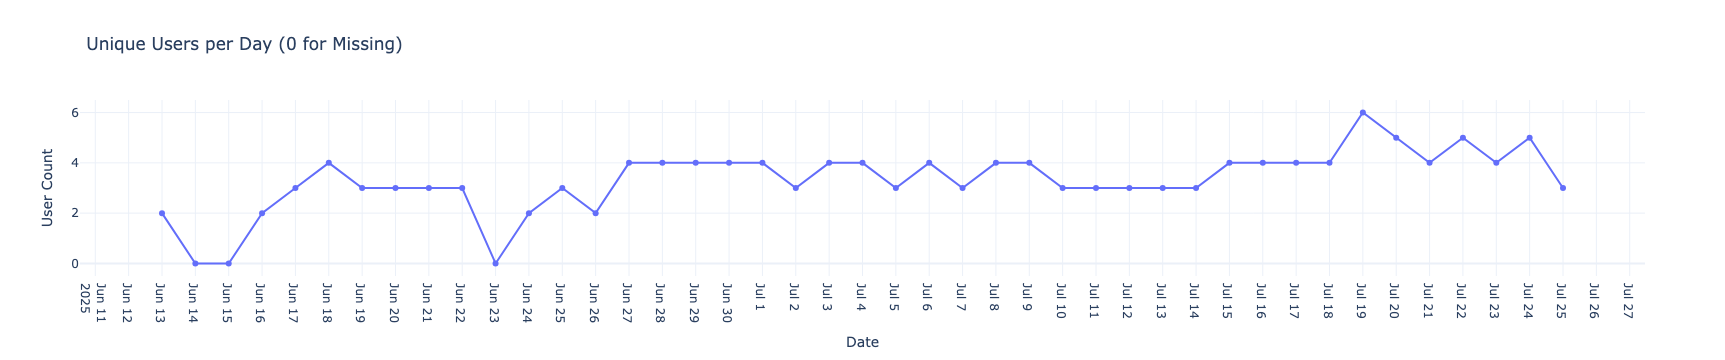

In [62]:
pio.templates.default = "seaborn"  # or "plotly_white", "ggplot2", "seaborn", etc.

# Step 1: Calculate daily users
dedup_df = users_score.unique(subset=["date_only", "user_id"])

daily_users = (
    dedup_df
    .group_by("date_only")
    .agg(pl.len().alias("user_count"))
    .sort("date_only")
)

# Step 2: Generate full date range in Polars
min_date = daily_users["date_only"].min()
max_date = daily_users["date_only"].max()

date_range_df = pl.DataFrame({
    "date_only": pl.date_range(min_date, max_date, interval="1d", eager=True)
})

# Step 3: Left join and fill missing values with 0
filled_users = (
    date_range_df
    .join(daily_users, on="date_only", how="left")
    .fill_null(strategy="zero")
)

# Step 4: Plot using Plotly (no pandas)
fig = go.Figure(
    data=go.Scatter(
        x=filled_users["date_only"].to_list(),
        y=filled_users["user_count"].to_list(),
        mode="lines+markers"
    )
)

fig.update_layout(
    title="Unique Users per Day (0 for Missing)",
    xaxis_title="Date",
    yaxis_title="User Count",
    xaxis=dict(type="date", dtick="D1"),
    template="plotly_white"
)

fig.show()


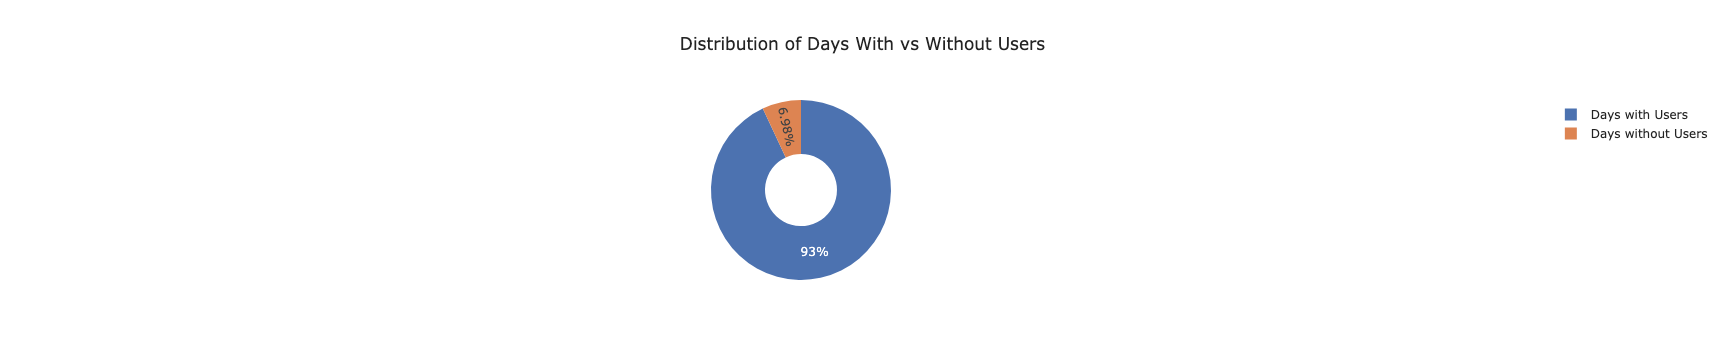

In [63]:
# Step 1: Count days with and without users
with_users = filled_users.filter(pl.col("user_count") > 0).height
without_users = filled_users.filter(pl.col("user_count") == 0).height

# Step 2: Create data for plot
labels = ["Days with Users", "Days without Users"]
values = [with_users, without_users]

# Step 3: Plot pie chart
fig = px.pie(
    names=labels,
    values=values,
    title="Distribution of Days With vs Without Users",
    hole=0.4  # donut style
)

fig.show()


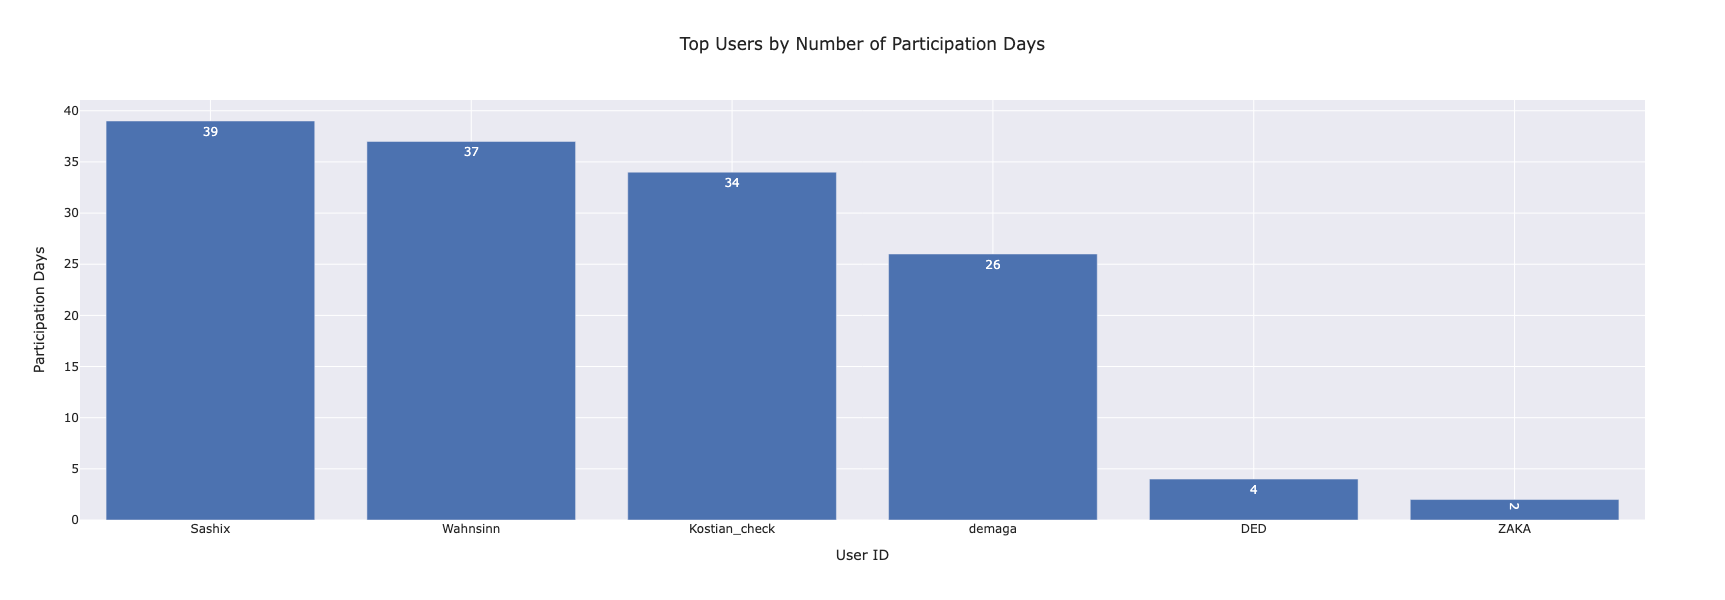

In [81]:
# Step 1: Calculate participation days per user
participation_count = (
    users_score
    .select(["user_nickname", "date_only"])
    .unique()
    .group_by("user_nickname")
    .agg(pl.len().alias("participation_days"))
    .sort("participation_days", descending=True)
    .limit(10)  # top 10 most active users
)

# Step 2: Plot using Plotly
fig = px.bar(
    x=participation_count["user_nickname"].to_list(),
    y=participation_count["participation_days"].to_list(),
    labels={"x": "User ID", "y": "Participation Days"},
    title="Top Users by Number of Participation Days",
    text=participation_count["participation_days"].to_list(),  # ← values on bars
    text_auto=True,
    height=600
)

fig.show()


In [65]:
# Step 1: All unique dates
all_dates = users_score.select("date_only").unique()

# Step 2: Dates where Sashix participated
sashix_dates = (
    users_score
    .filter(pl.col("user_nickname") == "Sashix")
    .select("date_only")
    .unique()
)

# Step 3: Find date(s) where Sashix did NOT participate
missing_dates = all_dates.join(sashix_dates, on="date_only", how="anti")
display(missing_dates)
users_score.filter(pl.col("date_only") == pl.date(2025, 6, 13))


date_only
date
2025-06-13


user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,object
690142381726892042,"""Kostian_check""",2025-06-13,"""2025-06-13T22:41:03.744000+00:00""",4,0,2,"""imgs/2025-06-13T22:41:03.744000+00:00.png""",[[0.0 1.0 0.5 0.0 0.0] [0.0 0.5 0.0 0.0 0.0] [1.0 0.0 0.0 0.5 0.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None] [None None None None None]]
444185680474800129,"""Wahnsinn""",2025-06-13,"""2025-06-13T22:41:03.744000+00:00""",null,1,2,"""imgs/2025-06-13T22:41:03.744000+00:00.png""",[[0. 0. 0. 0. 0. ] [0.5 0. 0. 0.5 0. ] [0.5 0. 0.5 0. 0. ] [1. 0.5 0.5 0. 0. ] [1. 0. 0.5 0.5 0.5] [1. 0.5 1. 1. 0. ]]


In [66]:
users_score.select("user_nickname", "score").describe()

statistic,user_nickname,score
str,str,f64
"""count""","""142""",124.0
"""null_count""","""0""",18.0
"""mean""",null,4.846774
"""std""",null,0.979832
"""min""","""DED""",3.0
"""25%""",null,4.0
"""50%""",null,5.0
"""75%""",null,6.0
"""max""","""demaga""",6.0


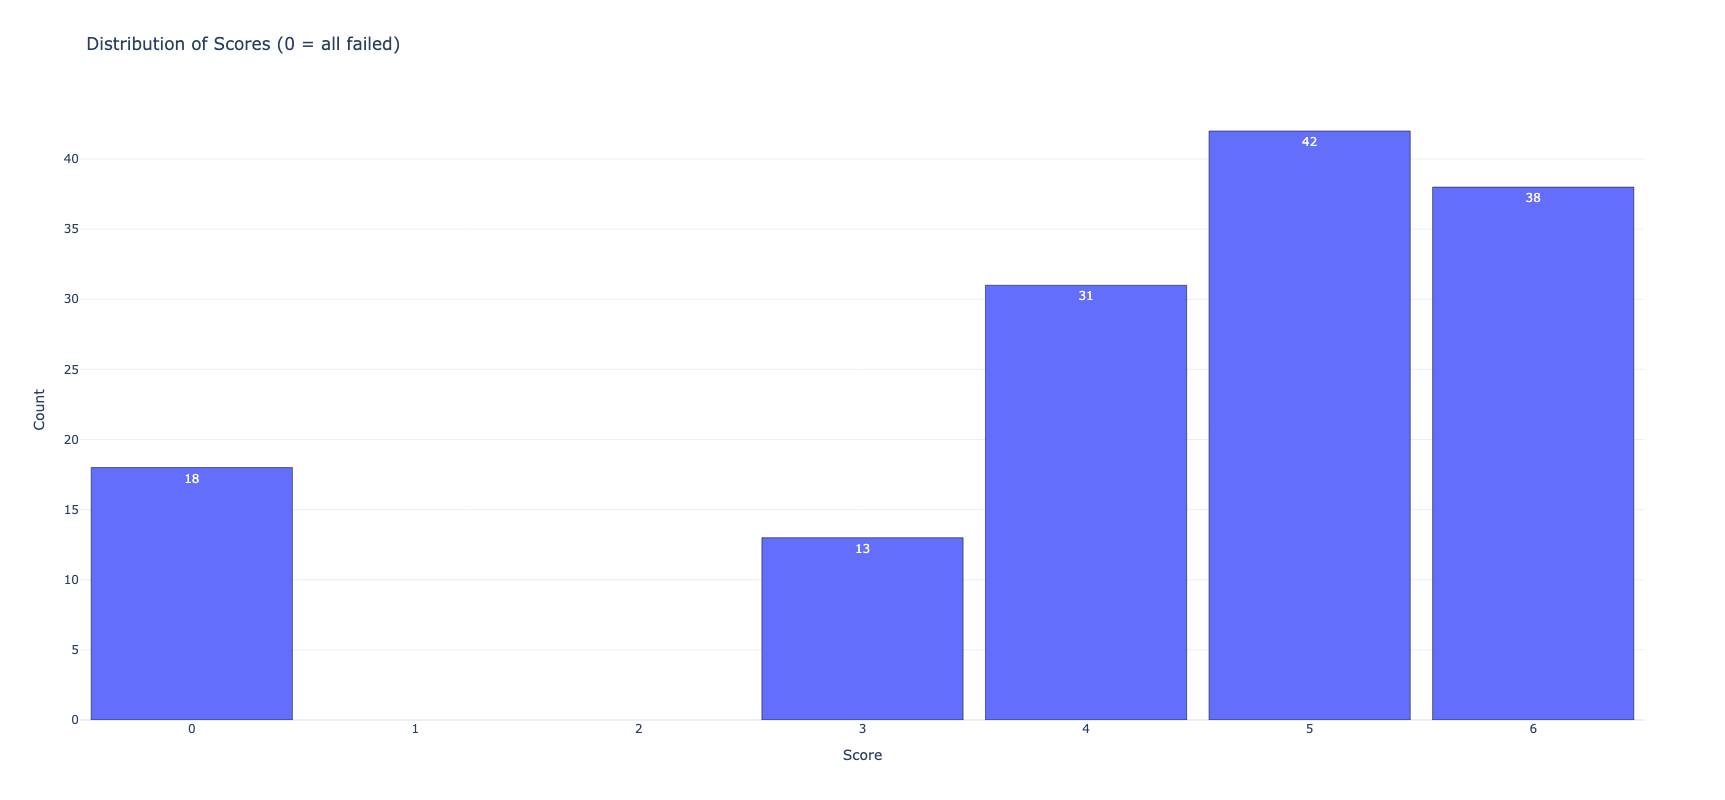

In [85]:
# Step 1: Count how many times each score appears (0–6)
score_distribution = (
    score_cleaned
    .group_by("score")
    .agg(pl.len().alias("count"))
    .sort("score")
)

# Step 2: Extract for plotting
x_vals = score_distribution["score"].to_list()
y_vals = score_distribution["count"].to_list()

# Step 3: Plot with go.Bar + text labels
fig = go.Figure(data=[
    go.Bar(
        x=x_vals,
        y=y_vals,
        text=y_vals,
        textposition='auto',
        marker=dict(
            line=dict(width=0.5, color='black')
        )
    )
])

fig.update_layout(
    title="Distribution of Scores (0 = all failed)",
    xaxis_title="Score",
    yaxis_title="Count",
    bargap=0.1,
    template="plotly_white",
    height=800
)

fig.show()


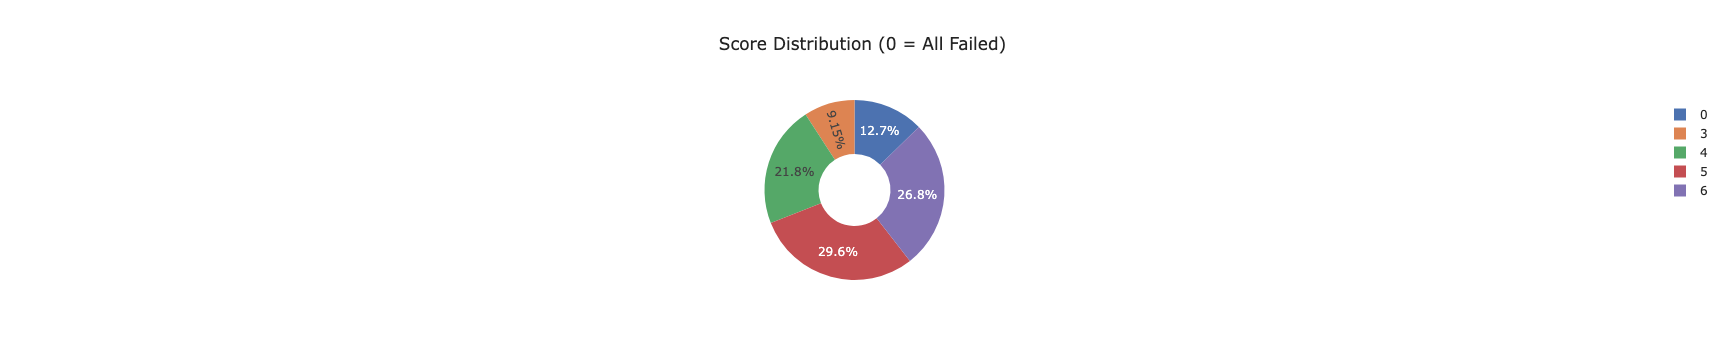

In [68]:
# Group and count by score (from existing score_filled)
score_distribution = (
    score_cleaned
    .group_by("score")
    .agg(pl.len().alias("count"))
    .sort("score")
)

# Extract and sort by score
scores = score_distribution["score"].to_list()
counts = score_distribution["count"].to_list()

# Sort (score, count) by score value
sorted_scores, sorted_counts = zip(*sorted(zip(scores, counts), key=lambda x: x[0]))

# Use graph_objects to plot with preserved order
fig = go.Figure(data=[
    go.Pie(
        labels=sorted_scores,
        values=sorted_counts,
        hole=0.4,
        sort=False  # ← disables sorting by values
    )
])

fig.update_layout(
    title="Score Distribution (0 = All Failed)"
)

fig.show()



In [69]:
pl.Config.set_tbl_rows(n=100)  # or any large number you expect
score_cleaned.filter(pl.col("score") == 0).select("user_nickname", "date_only")

user_nickname,date_only
str,date
"""Wahnsinn""",2025-07-24
"""Kostian_check""",2025-07-23
"""Kostian_check""",2025-07-21
"""Sashix""",2025-07-21
"""Kostian_check""",2025-07-16
"""Sashix""",2025-07-14
"""Kostian_check""",2025-07-12
"""Kostian_check""",2025-07-09
"""Wahnsinn""",2025-07-04


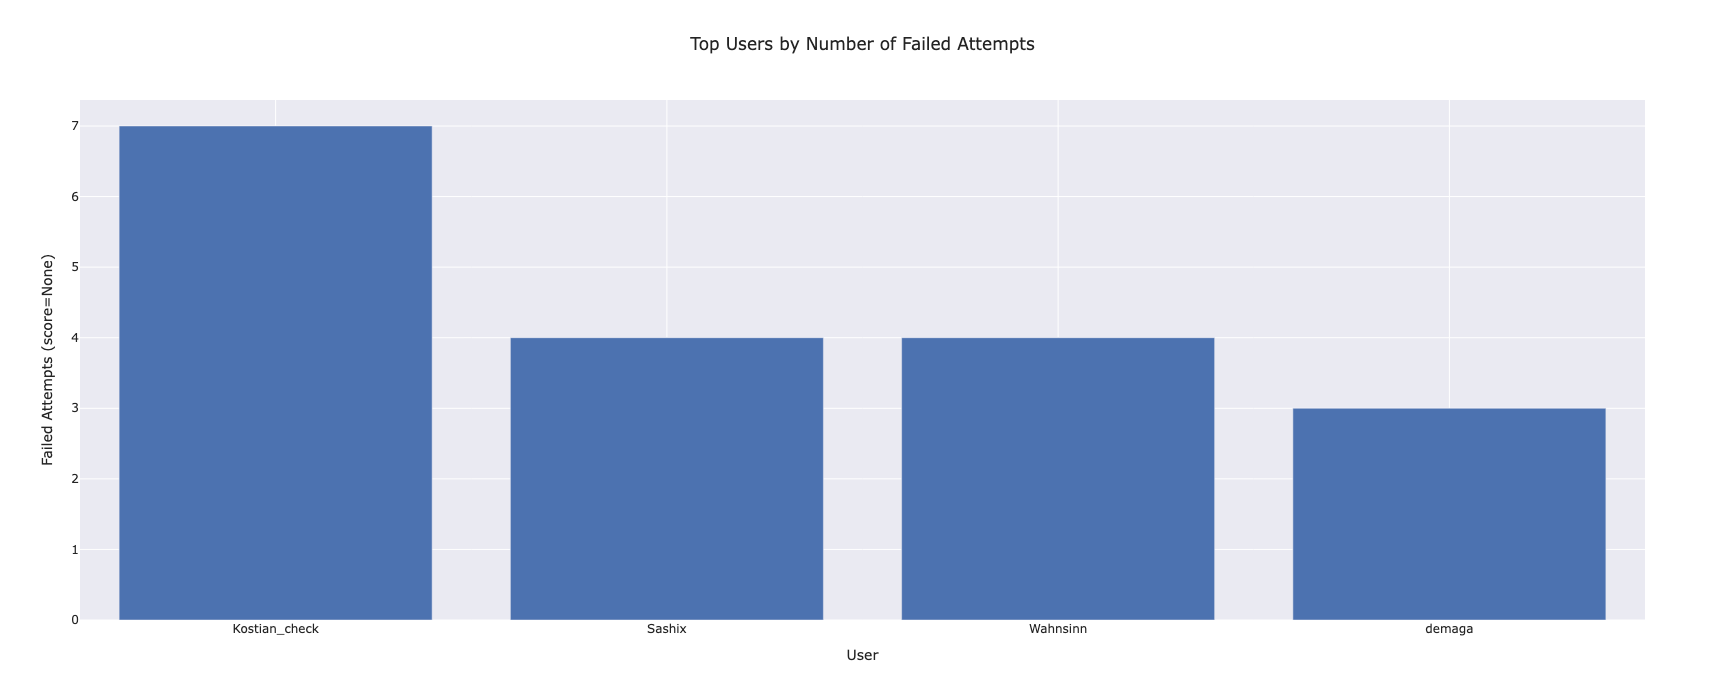

In [88]:
# Step 1–3: Get top users with most failed attempts
top_failures = (
    users_score
    .filter(pl.col("score").is_null())
    .group_by("user_nickname")
    .agg(pl.len().alias("fail_count"))
    .sort("fail_count", descending=True)
    .limit(10)
)

# Step 4: Plot
fig = px.bar(
    x=top_failures["user_nickname"].to_list(),
    y=top_failures["fail_count"].to_list(),
    labels={"x": "User", "y": "Failed Attempts (score=None)"},
    title="Top Users by Number of Failed Attempts",
    height=700
)

fig.show()

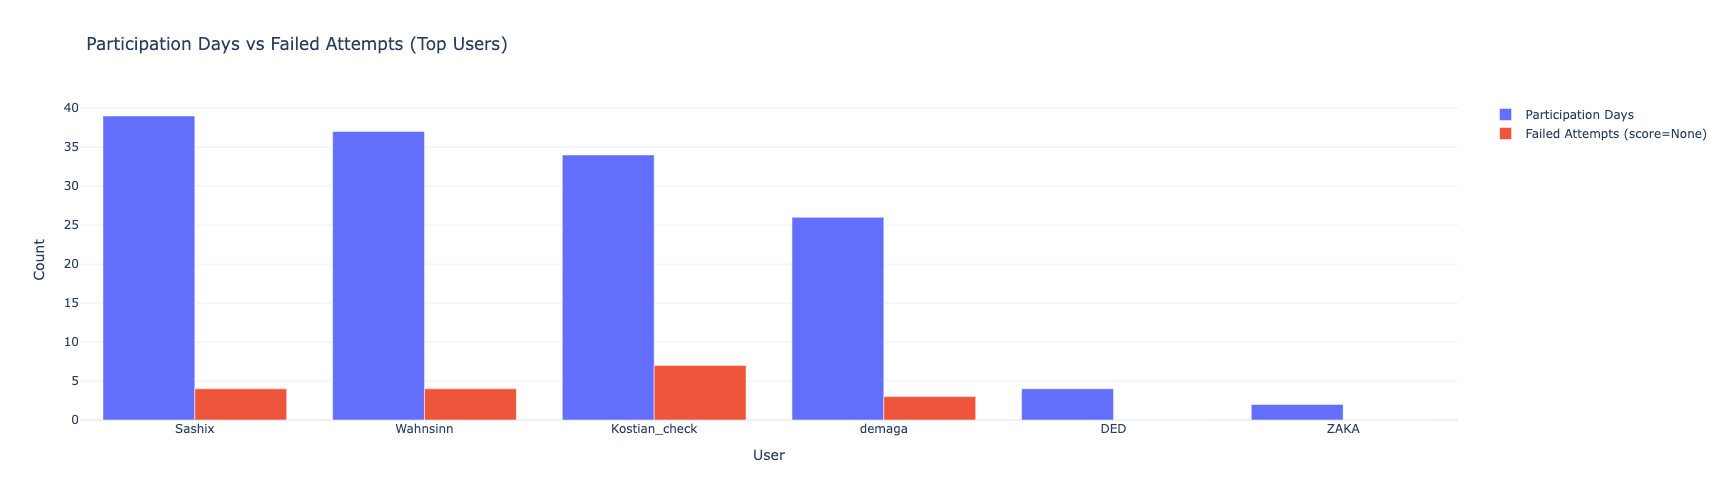

In [71]:
# Step 1: Join the two tables on user_nickname
combined_stats = (
    participation_count
    .join(top_failures, on="user_nickname", how="full")
    .fill_null(0)
    .sort("participation_days", descending=True)
)

# Step 2: Plot grouped bar chart
fig = go.Figure(data=[
    go.Bar(
        name="Participation Days",
        x=combined_stats["user_nickname"].to_list(),
        y=combined_stats["participation_days"].to_list()
    ),
    go.Bar(
        name="Failed Attempts (score=None)",
        x=combined_stats["user_nickname"].to_list(),
        y=combined_stats["fail_count"].to_list(),
    )
])

fig.update_layout(
    barmode="group",
    title="Participation Days vs Failed Attempts (Top Users)",
    xaxis_title="User",
    yaxis_title="Count",
    template="plotly_white",
    height=500
)

fig.show()


In [72]:
# best score
users_score.filter(pl.col("score").is_not_null()).sort("score", descending=False).select("user_nickname", "date_only", "score").head(20)

user_nickname,date_only,score
str,date,i64
"""demaga""",2025-07-20,3
"""DED""",2025-07-19,3
"""Wahnsinn""",2025-07-18,3
"""Kostian_check""",2025-07-13,3
"""Kostian_check""",2025-07-11,3
"""Kostian_check""",2025-07-08,3
"""demaga""",2025-06-30,3
"""Kostian_check""",2025-06-28,3
"""Sashix""",2025-06-28,3


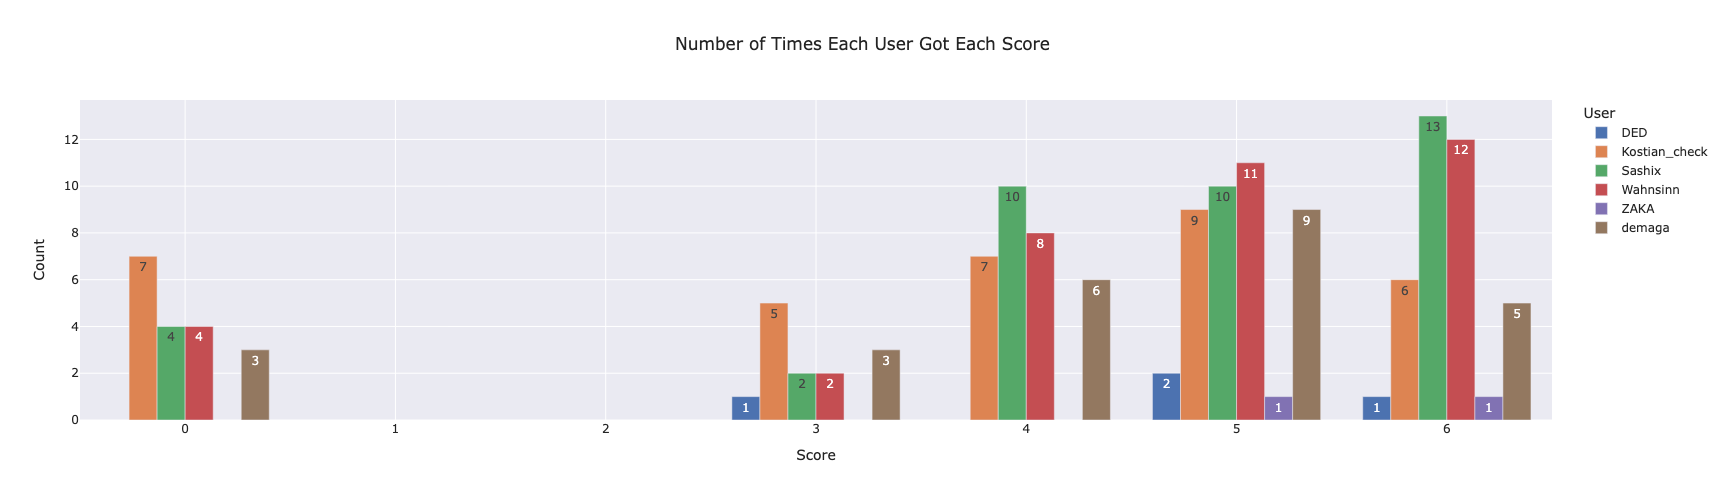

In [89]:
# Step 1: Fill nulls as 0
score_by_user = users_score.with_columns(
    pl.col("score").fill_null(0)
)

# Step 2: Group by user and score, count
score_counts = (
    score_by_user
    .group_by(["user_nickname", "score"])
    .agg(pl.len().alias("count"))
    .sort(["user_nickname", "score"])
)
fig = px.bar(
    score_counts,
    x="score",
    y="count",
    color="user_nickname",
    barmode="group",  # or 'stack' if you prefer
    title="Number of Times Each User Got Each Score",
    labels={"score": "Score", "count": "Count", "user_nickname": "User"},
    text="count",             # ← show values on bars
    text_auto=True,           # ← enable automatic formatting and placement
    height=500
)

fig.show()





In [74]:
score_stats_by_user = (
    users_score
    .filter(pl.col("score").is_not_null())
    .group_by("user_nickname")
    .agg([
        pl.col("score").len().alias("count"),
        pl.col("score").mean().alias("mean_score"),
        pl.col("score").median().alias("median_score"),
        pl.col("score").min().alias("min_score"),
        pl.col("score").max().alias("max_score"),
        pl.len().alias("num_games")
    ])
    .sort("mean_score", descending=True)
)
score_stats_by_user


user_nickname,count,mean_score,median_score,min_score,max_score,num_games
str,u32,f64,f64,i64,i64,u32
"""ZAKA""",2,5.5,5.5,5,6,2
"""Wahnsinn""",33,5.0,5.0,3,6,33
"""Sashix""",35,4.971429,5.0,3,6,35
"""DED""",4,4.75,5.0,3,6,4
"""demaga""",23,4.695652,5.0,3,6,23
"""Kostian_check""",27,4.592593,5.0,3,6,27


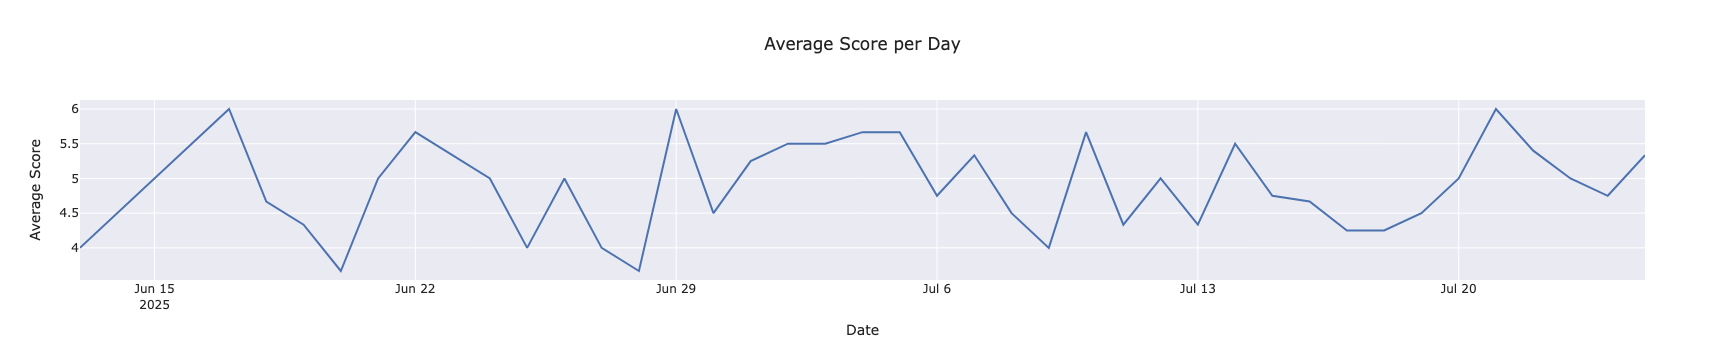

In [90]:
# Step 2: Average score per day
avg_score_per_day = (
    users_score.filter(pl.col("score").is_not_null())
    .group_by("date_only")
    .agg(pl.col("score").mean().alias("avg_score"))
    .sort("date_only")
)

# Step 3: Plot line chart
fig = px.line(
    x=avg_score_per_day["date_only"].to_list(),
    y=avg_score_per_day["avg_score"].to_list(),
    title="Average Score per Day",
    labels={"x": "Date", "y": "Average Score"}
)

fig.show()


# Matrices Charts

In [35]:
# users_score.select("matrices", "user_nickname", "date_only")

In [36]:
# def proccess_image(img_path: str, user_number: int, output_type: str = "int"):
#     for users_cnt, layout in result_grid.items():
#         print(f"{users_cnt=}")
#         print(f"{user_number=}")
#         print(layout)
#         daily_image = cv2.imread(img_path)
#         matrix = get_daily_results(daily_image, layout, output_type)[user_number-1]
#         matrix = np.array(matrix)
#         contains_none = np.any(matrix == -1000000.0)
#         if not contains_none:
#             return matrix


# users_score_test = users_score.filter(pl.col("date_only") == pl.date(2025, 6, 18)) \
#     .with_columns([
#     pl.struct(["img_path", "users_cnt", "user_number"]).map_elements(
#         lambda row: proccess_image(row["img_path"], row["users_cnt"], row["user_number"])
#     ).alias("matrices")
# ])
# print_matrix(users_score_test.select("matrices").head(1).item())
# users_score_test

In [76]:
users_score_with_matrices = users_score.with_columns([
    pl.struct(["img_path", "users_cnt", "user_number"]).map_elements(
        lambda row: proccess_image(row["img_path"], row["users_cnt"], row["user_number"])
    ).alias("matrices")
])
users_score_with_matrices.select("matrices", "user_nickname", "date_only").filter(pl.col("date_only") != pl.date(2025, 6, 18)).head(100)

/var/folders/6k/pgkjzwf5565dsnb9yf06xcxm0000gn/T/ipykernel_16243/3999467834.py:1: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



matrices,user_nickname,date_only
object,str,date
[[0.0 0.5 0.0 0.0 0.5] [0.5 0.5 0.0 0.0 0.0] [0.0 0.5 0.5 0.0 0.0] [0.0 1.0 0.0 0.0 0.5] [1.0 1.0 1.0 1.0 1.0] [None None None None None]],"""Kostian_check""",2025-07-25
[[0.5 0.5 0.0 0.0 0.0] [0.0 1.0 0.5 1.0 0.0] [1.0 1.0 0.0 1.0 1.0] [1.0 1.0 0.0 1.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]],"""Sashix""",2025-07-25
[[0. 0. 0. 1. 0.] [0. 0. 0. 1. 1.] [0. 0. 0. 1. 1.] [0. 0. 0. 1. 1.] [0. 1. 0. 1. 1.] [1. 1. 1. 1. 1.]],"""Wahnsinn""",2025-07-25
[[0.0 0.0 1.0 0.0 0.0] [0.0 0.0 0.5 0.0 0.0] [0.5 0.0 1.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None] [None None None None None]],"""Kostian_check""",2025-07-24
[[0.0 0.0 0.0 0.0 0.0] [0.0 0.0 1.0 0.0 0.0] [0.0 0.5 1.0 0.0 0.0] [0.0 0.0 1.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]],"""Sashix""",2025-07-24
[[0.0 0.0 0.0 0.0 0.0] [0.0 1.0 0.0 0.0 0.0] [0.0 1.0 0.5 0.5 0.0] [0.0 0.5 0.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]],"""DED""",2025-07-24
[[0.0 0.0 0.0 0.5 0.0] [0.0 0.5 1.0 0.0 0.0] [0.0 0.0 1.0 0.0 1.0] [0.0 0.0 1.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]],"""demaga""",2025-07-24
[[0. 0. 0. 0.5 0. ] [0.5 0. 0. 0.5 0. ] [0. 1. 0. 0.5 0. ] [0. 1. 0. 0. 1. ] [0. 1. 0. 0. 0. ] [1. 1. 1. 0. 1. ]],"""Wahnsinn""",2025-07-24
[[0.0 1.0 0.0 1.0 0.5] [0.5 1.0 0.0 1.0 1.0] [0.0 1.0 1.0 1.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None] [None None None None None]],"""demaga""",2025-07-23


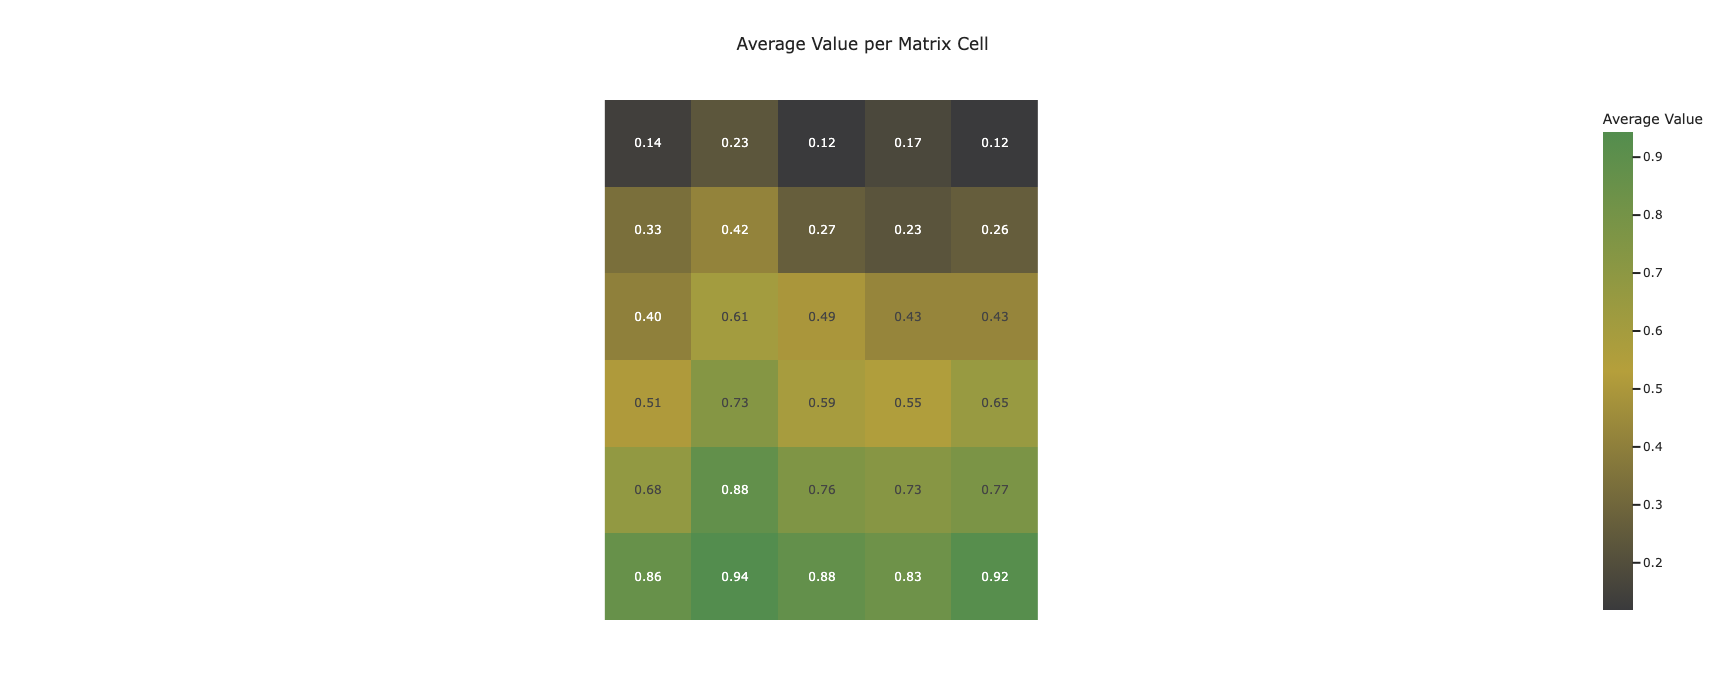

In [104]:
# Extract all matrices as a list of 2D arrays
all_matrices = users_score.filter(pl.col("date_only") != pl.date(2025, 6, 18)).filter(pl.col("date_only") != pl.date(2025, 7, 12))["matrices"].to_list()

# Convert to a 3D numpy array (num_matrices, 6, 5), with np.nan for None
matrix_stack = np.array([
    [[cell if cell is not None else np.nan for cell in row] for row in matrix]
    for matrix in all_matrices
])
# Average over axis 0 (the matrix "samples")
mean_matrix = np.nanmean(matrix_stack, axis=0)

fig = px.imshow(
    mean_matrix,
    labels=dict(color="Average Value"),
    title="Average Value per Matrix Cell",
    text_auto=".2f",  # show values inside cells
    aspect="auto",
    color_continuous_scale= ["#3a3a3c", "#b59f3b", "#538d4e"],
    height=700
)

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        showline=False
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        showline=False,
        scaleanchor="x",  # still keep square cells
        scaleratio=1
    ),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

In [78]:
import numpy as np

emoji_map = {
    1.0 : "🟩",
    0.5: "🟨",
    0.0: "⬜️",
    None: "⬛",
    np.nan: "⬛"
}
    
# Step 1: Clean matrix (replace None with np.nan)
def to_clean_matrix(matrix):
    return np.array([
        [cell if cell is not None else np.nan for cell in row]
        for row in matrix
    ], dtype=float)

# Step 2: Prepare all cleaned matrices
matrices = [to_clean_matrix(m) for m in all_matrices]
n = len(matrices)

# Step 3: Similarity function
def matrix_similarity(a, b, tolerance=0.01):
    mask = ~np.isnan(a) & ~np.isnan(b)
    total = np.sum(mask)
    
    # Match if values are equal or one is 1 and the other is 0.5
    match_mask = (
        (np.abs(a - b) < tolerance) |  # exact match (e.g. 1 == 1, 0.5 == 0.5, 0 == 0)
        ((a == 1) & (b == 0.5)) |
        ((a == 0.5) & (b == 1))
    )
    
    matches = np.sum(match_mask & mask)
    return matches / total if total > 0 else 0

# Step 4: Compute similarity matrix (n x n)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        sim = matrix_similarity(matrices[i], matrices[j])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim  # symmetry

# Step 5: Find closest pair
max_sim = -1
best_pairs = []

for i in range(n):
    for j in range(i + 1, n):
        if i != j and similarity_matrix[i, j] > 0.9:
            max_sim = similarity_matrix[i, j]
            best_pairs.append((i, j))

# users_score[best_pair[0]]

fixed_useers_score = users_score.filter(pl.col("date_only") != pl.date(2025, 6, 18)).filter(pl.col("date_only") != pl.date(2025, 7, 12))

for best_pair in best_pairs[:3]:
    display(fixed_useers_score[best_pair[0]])
    display(fixed_useers_score[best_pair[1]])
    print(f"✅ Closest matrices are #{best_pair[0]} and #{best_pair[1]} with similarity {max_sim:.2f}")
    print("Matrix A:")
    for row in matrices[best_pair[0]]:
        for el in row:
            print(emoji_map.get(el, "⬛️"), end="")
        print("")
    print("Matrix B:")
    for row in matrices[best_pair[1]]:
        for el in row:
            print(emoji_map.get(el, "⬛️"), end="")
        print("")
    print("=" * 10)



user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,object
662414928350806044,"""demaga""",2025-07-20,"""2025-07-20T22:48:11.667000+00:00""",3,0,5,"""imgs/2025-07-20T22:48:11.667000+00:00.png""",[[1.0 0.0 0.0 0.5 1.0] [1.0 0.5 0.0 0.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None] [None None None None None] [None None None None None]]


user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,object
394171450120208389,"""Sashix""",2025-06-28,"""2025-06-28T21:55:28.067000+00:00""",3,1,4,"""imgs/2025-06-28T21:55:28.067000+00:00.png""",[[0.0 0.0 0.0 0.5 0.5] [1.0 1.0 0.0 0.0 0.5] [1.0 1.0 1.0 1.0 1.0] [None None None None None] [None None None None None] [None None None None None]]


✅ Closest matrices are #21 and #102 with similarity 0.93
Matrix A:
🟩⬜️⬜️🟨🟩
🟩🟨⬜️⬜️🟩
🟩🟩🟩🟩🟩
⬛️⬛️⬛️⬛️⬛️
⬛️⬛️⬛️⬛️⬛️
⬛️⬛️⬛️⬛️⬛️
Matrix B:
⬜️⬜️⬜️🟨🟨
🟩🟩⬜️⬜️🟨
🟩🟩🟩🟩🟩
⬛️⬛️⬛️⬛️⬛️
⬛️⬛️⬛️⬛️⬛️
⬛️⬛️⬛️⬛️⬛️


user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,object
394171450120208389,"""Sashix""",2025-07-10,"""2025-07-10T22:12:11.547000+00:00""",6,1,3,"""imgs/2025-07-10T22:12:11.547000+00:00.png""",[[0. 0. 0. 0. 0.] [0. 0. 0. 1. 0.] [0. 1. 0. 0. 0.] [0. 1. 1. 1. 1.] [0. 1. 1. 1. 1.] [1. 1. 1. 1. 1.]]


user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,object
394171450120208389,"""Sashix""",2025-07-03,"""2025-07-03T21:51:18.392000+00:00""",6,1,4,"""imgs/2025-07-03T21:51:18.392000+00:00.png""",[[0. 0. 0. 0. 0. ] [0. 0. 0. 0.5 0. ] [0. 0. 0. 0. 0. ] [0. 1. 1. 1. 1. ] [0. 1. 1. 1. 1. ] [1. 1. 1. 1. 1. ]]


✅ Closest matrices are #58 and #83 with similarity 0.93
Matrix A:
⬜️⬜️⬜️⬜️⬜️
⬜️⬜️⬜️🟩⬜️
⬜️🟩⬜️⬜️⬜️
⬜️🟩🟩🟩🟩
⬜️🟩🟩🟩🟩
🟩🟩🟩🟩🟩
Matrix B:
⬜️⬜️⬜️⬜️⬜️
⬜️⬜️⬜️🟨⬜️
⬜️⬜️⬜️⬜️⬜️
⬜️🟩🟩🟩🟩
⬜️🟩🟩🟩🟩
🟩🟩🟩🟩🟩


user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,object
662414928350806044,"""demaga""",2025-07-08,"""2025-07-09T05:21:04.944000+00:00""",5,1,4,"""imgs/2025-07-09T05:21:04.944000+00:00.png""",[[0.0 0.5 0.0 0.0 0.0] [0.5 0.0 0.0 0.5 0.5] [0.5 0.5 0.5 0.0 0.0] [0.0 1.0 1.0 1.0 1.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]]


user_id,user_nickname,date_only,timestamp_raw,score,user_number,users_cnt,img_path,matrices
i64,str,date,str,i64,i64,i64,str,object
444185680474800129,"""Wahnsinn""",2025-07-08,"""2025-07-09T05:21:04.944000+00:00""",5,3,4,"""imgs/2025-07-09T05:21:04.944000+00:00.png""",[[0.0 0.5 0.0 0.5 0.0] [0.5 0.0 0.0 0.5 0.5] [0.5 0.5 0.5 0.0 0.0] [0.0 1.0 1.0 1.0 0.0] [1.0 1.0 1.0 1.0 1.0] [None None None None None]]


✅ Closest matrices are #65 and #67 with similarity 0.93
Matrix A:
⬜️🟨⬜️⬜️⬜️
🟨⬜️⬜️🟨🟨
🟨🟨🟨⬜️⬜️
⬜️🟩🟩🟩🟩
🟩🟩🟩🟩🟩
⬛️⬛️⬛️⬛️⬛️
Matrix B:
⬜️🟨⬜️🟨⬜️
🟨⬜️⬜️🟨🟨
🟨🟨🟨⬜️⬜️
⬜️🟩🟩🟩⬜️
🟩🟩🟩🟩🟩
⬛️⬛️⬛️⬛️⬛️
